In [4]:
# Imports
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import defaultdict
import numpy as np

import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Dense, BatchNormalization

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Exercise Summary:
               Exercise  Total Videos                  Formats  Total Size (MB)  Size Std (MB) Total Duration Duration Std
0         russian twist            13          MOV: 1, mp4: 12           123.95      19.500000           3:35         0:15
1               push-up            56                  mp4: 56            68.65       2.160000           5:31         0:04
2           tricep dips            20          MOV: 4, mp4: 16           265.03      14.030000           4:09         0:06
3     romanian deadlift            14  mov: 2, mp4: 10, MOV: 2           267.85      19.750000           4:19         0:25
4             t bar row            21          MOV: 7, mp4: 14           312.99      11.980000           4:10         0:05
5               pull Up            26                  mp4: 26           140.04       6.400000           3:29         0:05
6       tricep Pushdown            50                  mp4: 50            81.71       2.660000           3:17         0:

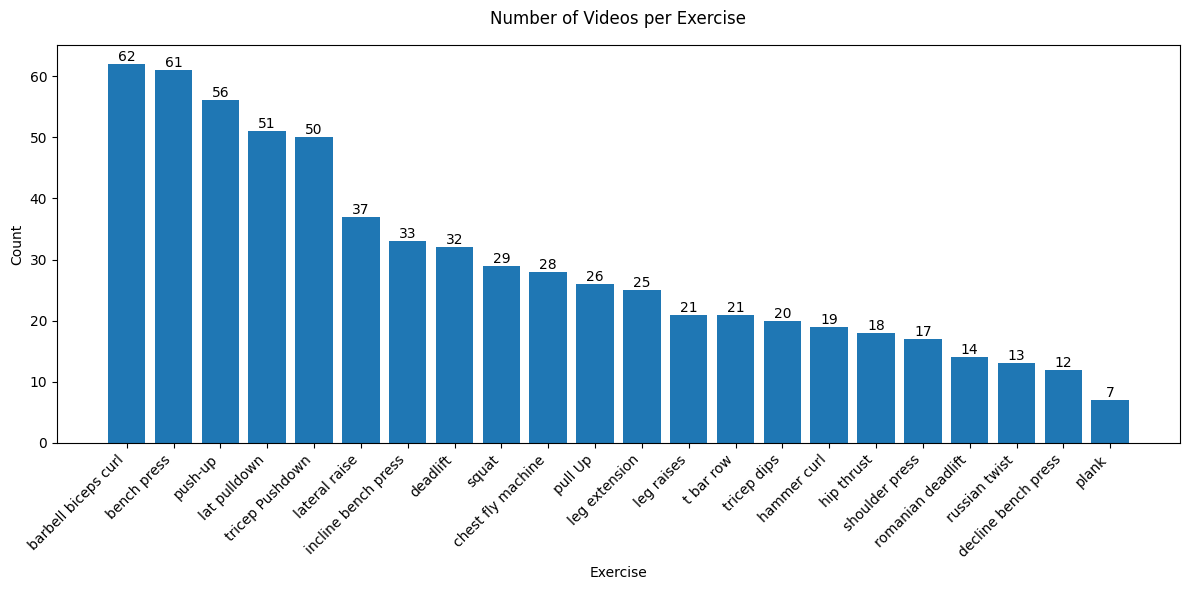

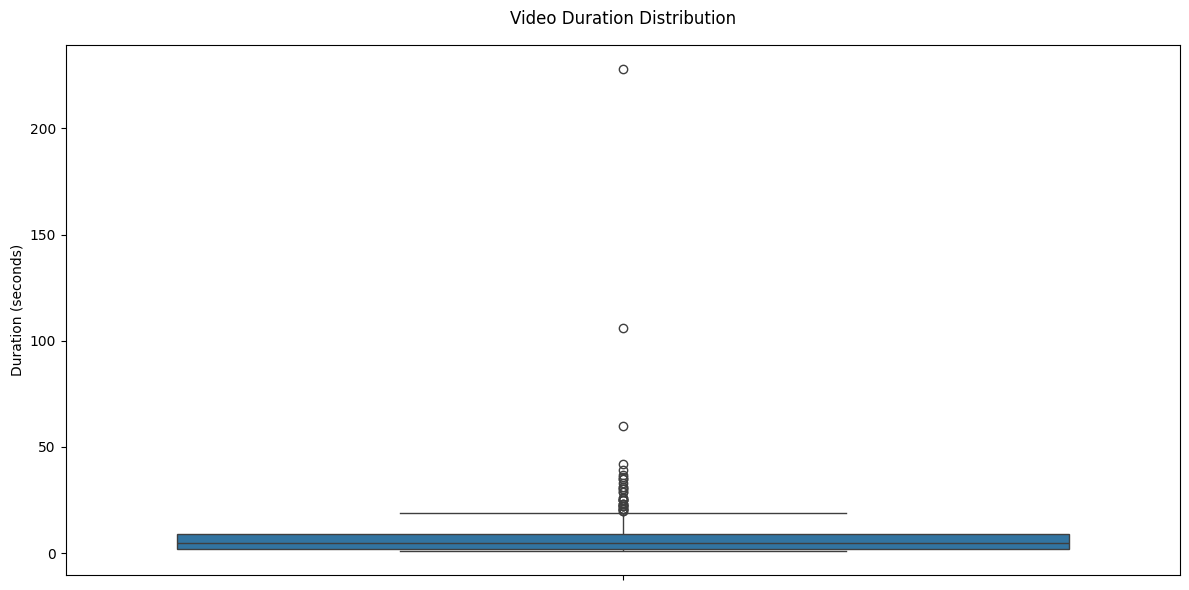

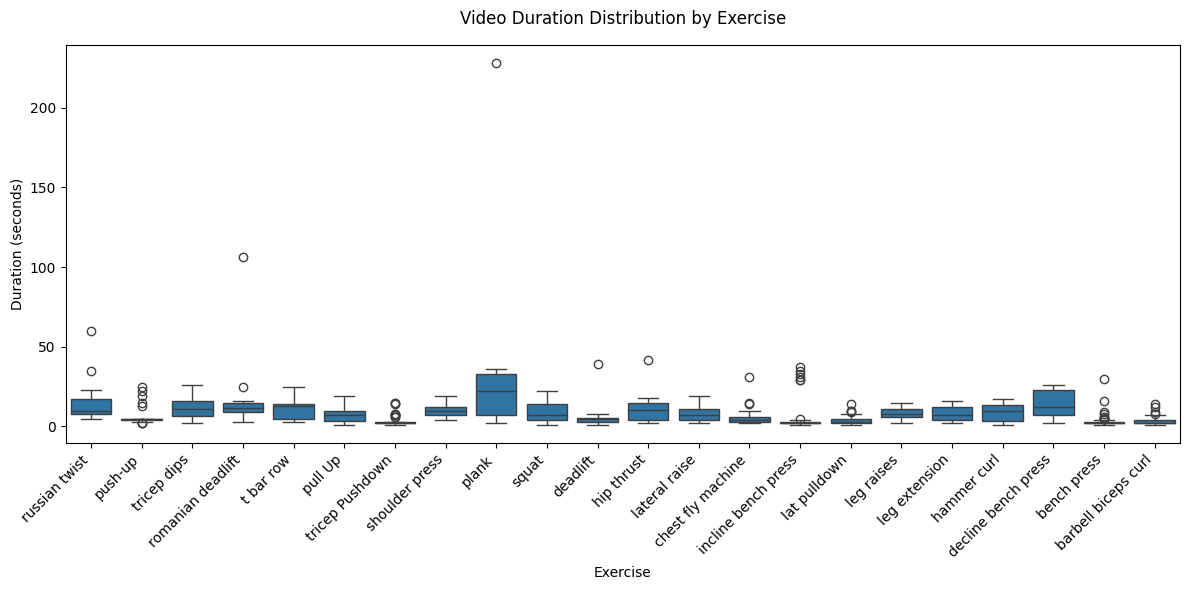

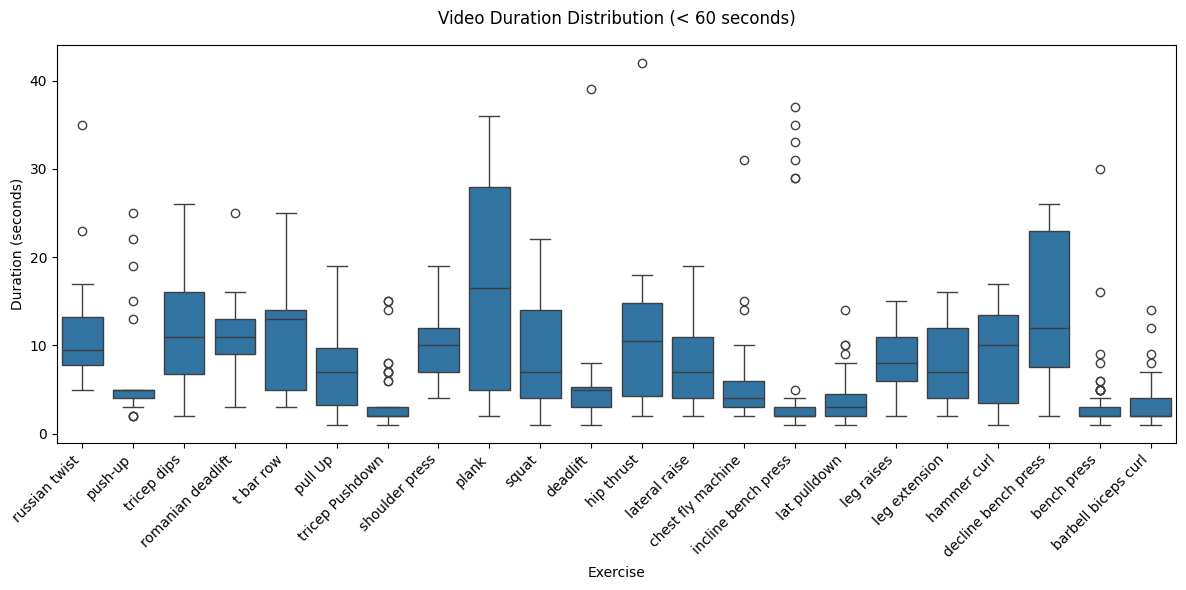

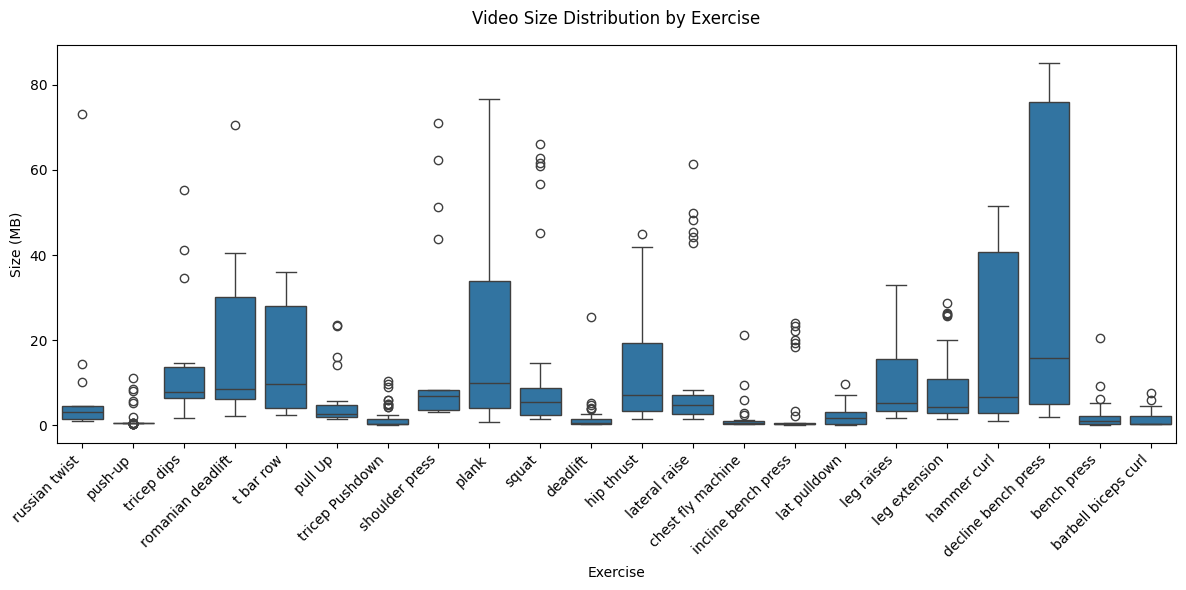

In [6]:
# Function to retrieve the duration of a video file
def get_video_duration(file_path):
    try:
        video = cv2.VideoCapture(file_path)
        fps = video.get(cv2.CAP_PROP_FPS)
        frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
        duration = frame_count / fps if fps > 0 else 0
        video.release()
        return round(duration, 2)
    except Exception as error:
        print(f"Failed to get duration for {file_path}: {error}")
        return 0

# Function to gather metadata for all video files in a directory
def get_video_metadata(base_folder):
    metadata = defaultdict(list)

    for root, _, files in os.walk(base_folder):
        exercise_name = os.path.basename(root)

        for file in files:
            if file.lower().endswith(('.mp4', '.mov', '.avi', '.mkv', '.wmv')):
                file_path = os.path.join(root, file)
                try:
                    file_size = round(os.path.getsize(file_path) / (1024 * 1024), 2)  # Size in MB
                    last_modified = datetime.fromtimestamp(os.path.getmtime(file_path))
                    duration = get_video_duration(file_path)

                    metadata[exercise_name].append({
                        'name': file,
                        'size_mb': file_size,
                        'format': file.split('.')[-1],
                        'modified': last_modified.strftime('%Y-%m-%d %H:%M'),
                        'duration': duration
                    })
                except Exception as error:
                    print(f"Error processing {file}: {error}")

    return metadata

# Helper functions to format durations
def format_duration(seconds):
    minutes = int(seconds // 60)
    remaining_seconds = int(seconds % 60)
    return f"{minutes}:{remaining_seconds:02d}"

def convert_time_to_seconds(time_str):
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

# Create summary and detailed DataFrames from the gathered metadata
def generate_dataframes(metadata):
    summary_data = []
    detailed_data = []

    for exercise, videos in metadata.items():
        if videos:
            formats = {}
            total_size = 0
            total_duration = 0
            sizes = []
            durations = []

            for video in videos:
                format_type = video['format']
                formats[format_type] = formats.get(format_type, 0) + 1
                total_size += video['size_mb']
                total_duration += video['duration']
                sizes.append(video['size_mb'])
                durations.append(video['duration'])

            summary_data.append({
                'Exercise': exercise,
                'Total Videos': len(videos),
                'Formats': ', '.join(f"{fmt}: {count}" for fmt, count in formats.items()),
                'Total Size (MB)': round(total_size, 2),
                'Size Std (MB)': round(pd.Series(sizes).std(), 2) if len(sizes) > 1 else 0,
                'Total Duration': format_duration(total_duration),
                'Duration Std': format_duration(pd.Series(durations).std()) if len(durations) > 1 else "0:00"
            })

            for video in videos:
                detailed_data.append({
                    'Exercise': exercise,
                    'Video Name': video['name'],
                    'Format': video['format'],
                    'Size (MB)': video['size_mb'],
                    'Duration': format_duration(video['duration']),
                    'Last Modified': video['modified']
                })

    summary_df = pd.DataFrame(summary_data)
    detailed_df = pd.DataFrame(detailed_data)

    total_row = {
        'Exercise': 'Total',
        'Total Videos': summary_df['Total Videos'].sum(),
        'Formats': 'All',
        'Total Size (MB)': summary_df['Total Size (MB)'].sum(),
        'Size Std (MB)': summary_df['Size Std (MB)'].mean(),
        'Total Duration': format_duration(sum(pd.Series([convert_time_to_seconds(x) for x in summary_df['Total Duration']]))),
        'Duration Std': format_duration(pd.Series([convert_time_to_seconds(x) for x in summary_df['Duration Std']]).mean())
        }
    summary_df = pd.concat([summary_df, pd.DataFrame([total_row])], ignore_index=True)

    return summary_df, detailed_df

# Running the analysis
base_folder = "/content/drive/MyDrive/CVP/CV_PData"
metadata = get_video_metadata(base_folder)
summary_df, detailed_df = generate_dataframes(metadata)

# Display results
print("\nExercise Summary:")
print(summary_df.to_string())
print("\nDetailed Video List:")
print(detailed_df.to_string())

# Add a column with duration in seconds
detailed_df['Duration_Seconds'] = detailed_df['Duration'].apply(convert_time_to_seconds)

# Visualize data with plots
fig_size = (12, 6)

# Number of Videos per Exercise
plt.figure(figsize=fig_size)
video_counts = detailed_df['Exercise'].value_counts()
bars = plt.bar(video_counts.index, video_counts.values)
plt.title('Number of Videos per Exercise', pad=15)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Exercise')
plt.ylabel('Count')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Video Duration Distribution (Overall)
plt.figure(figsize=fig_size)
sns.boxplot(data=detailed_df, y='Duration_Seconds')
plt.title('Video Duration Distribution', pad=15)
plt.ylabel('Duration (seconds)')
plt.tight_layout()
plt.show()

# Duration Distribution by Exercise
plt.figure(figsize=fig_size)
sns.boxplot(data=detailed_df, x='Exercise', y='Duration_Seconds')
plt.title('Video Duration Distribution by Exercise', pad=15)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Exercise')
plt.ylabel('Duration (seconds)')
plt.tight_layout()
plt.show()

# Duration Distribution for Videos < 60 Seconds
plt.figure(figsize=fig_size)
sns.boxplot(data=detailed_df[detailed_df['Duration_Seconds']<60], x='Exercise', y='Duration_Seconds')
plt.title('Video Duration Distribution (< 60 seconds)', pad=15)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Exercise')
plt.ylabel('Duration (seconds)')
plt.tight_layout()
plt.show()

# Video Size Distribution by Exercise
plt.figure(figsize=fig_size)
sns.boxplot(data=detailed_df, x='Exercise', y='Size (MB)')
plt.title('Video Size Distribution by Exercise', pad=15)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Exercise')
plt.ylabel('Size (MB)')
plt.tight_layout()
plt.show()